## Life history traits model  
Taylor Chapter 3  
model to predict age-structured life history traits of understudied Carcharhinid species

### Set up notebook

In [1]:
#import packages
import datetime 
from itertools import product
import logging
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import os
from math import isnan
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import seaborn as sns
import pymc3 as pm  
from theano import tensor as tt
from theano import shared
import arviz as az
import warnings

%matplotlib inline  
#%matplotlib inline is a magic function that renders the figure in a notebook (instead of displaying a dump of the figure object)
from matplotlib import pyplot as plt 
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import FuncFormatter, StrMethodFormatter


In [2]:
# Aaron Helper function
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: [ b.index(x) if x in b else None for x in a ]
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdise(x):
    return (x-np.mean(x))/(np.std(x)*2)

def invlogit(x):
    return np.exp(x)/(1+np.exp(x))

def gelplot(pj,vector,posy,csize=40,lwd50=7,lwd95=1):
    if np.percentile(vector,2.5)<0 and 0<np.percentile(vector,97.5):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='grey')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='grey')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='grey')
    else:
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='black')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='black')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='black')
        
    if np.percentile(vector,25)<0 and 0<np.percentile(vector,75):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='white')

In [3]:
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Data\\for model\\in')
os.listdir() # list files in directory

['age_structured_traits.xlsx',
 'car_trait_covariates_v2.xlsx',
 'full_dataset.xlsx',
 'species_level_traits_v1.xlsx',
 '~$car_trait_covariates_v2.xlsx',
 '~$full_dataset.xlsx']

### Import and structure data

In [4]:
# Import full dataset
data = pd.read_excel('full_dataset.xlsx')
#get rid of species that don't have full complement of trait data
data = data[data.param_complete==0]
data.head()

Species     Stock   Stock_Year  Age  maturity survivorship  \
0  Carcharhinus tilstoni  ABTP-SWP  ABTP-SWP-13    0  0.000000          NaN   
1  Carcharhinus tilstoni  ABTP-SWP  ABTP-SWP-13    1  0.000000          NaN   
2  Carcharhinus tilstoni  ABTP-SWP  ABTP-SWP-13    2  0.000000          NaN   
3  Carcharhinus tilstoni  ABTP-SWP  ABTP-SWP-13    3  0.000000          NaN   
4  Carcharhinus tilstoni  ABTP-SWP  ABTP-SWP-13    4  0.016088          NaN   

   fecundity (num female pups per year) notes model type  source_mat  ...  \
0                                   NaN   NaN        NaN  Harry 2013  ...   
1                                   NaN   NaN        NaN  Harry 2013  ...   
2                                   NaN   NaN        NaN  Harry 2013  ...   
3                                   NaN   NaN        NaN  Harry 2013  ...   
4                                   NaN   NaN        NaN  Harry 2013  ...   

  age_50_maturity length_maturity_cm linf_cm growth_coeff_k lmax_cm  \
0             6.1              125.0   218.0          0.089   166.0   
1             6.1              125.0   218.0          0.089   166.0   
2             6.1              125.0   218.0          0.089   166.0   
3             6.1              125.0   218.0          0.089   166.0   
4             6.1              125.0   218.0          0.089   166.0   

   age_max_yrs temp_pref nursery depth_ave param_complete  
0         15.0       0.0     0.0      75.0            0.0  
1         15.0       0.0     0.0      75.0            0.0  
2         15.0       0.0     0.0      75.0            0.0  
3         15.0       0.0     0.0      75.0            0.0  
4         15.0       0.0     0.0      75.0            0.0  

[5 rows x 35 columns]

In [7]:
# Add  offspring size and  litter size relative to length at maturity
# Within a single species many studies look at the relationship between litter size/offspring size and maternal body size. 
# But I want to look at differences between species.  
# Offspring size relative to maternal body size says something about how much energy the mother puts into offpsring, which should relate to a50 and perahps s.
#cdata['treatment'] = 1 + cdata.prosoc_left + 2*cdata.condition
data['relative_litter_size'] = data.litter_size/data.length_maturity_cm
data['relative_offspring_size'] = (data.offspring_size_mm/10)/data.length_maturity_cm

In [8]:
#list columns
data.columns

Index(['Species', 'Stock', 'Stock_Year', 'Age', 'maturity', 'survivorship',
       'fecundity (num female pups per year)', 'notes', 'model type',
       'source_mat', 'source_sur', 'source_fec', 'source_m_link',
       'source_s_link', 'source_f_link', 'Cortes_2018', 'SA_mat', 'SA_sur',
       'SA_fec', 'FP_species', 'habitat', 'trophic_level', 'offspring_size_mm',
       'litter_size', 'interbirth_interval_yrs', 'age_50_maturity',
       'length_maturity_cm', 'linf_cm', 'growth_coeff_k', 'lmax_cm',
       'age_max_yrs', 'temp_pref', 'nursery', 'depth_ave', 'param_complete',
       'relative_litter_size', 'relative_offspring_size'],
      dtype='object')

In [9]:
# make datafame of only stocks which have age-structured maturity data
# only data rows where SA-mat A
mdata= data[data.SA_mat=='A']
mdata.shape

(505, 37)

In [10]:
# make sure data is sorted properly
mdata = mdata.sort_values(by=['Stock_Year', 'Age'])

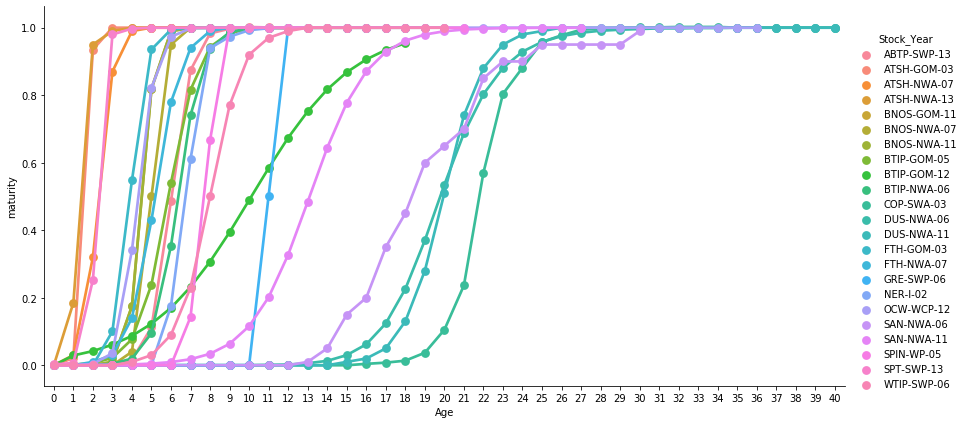

In [11]:
# visualise age-structured data
sns.catplot(x = "Age", y = "maturity", hue = "Stock_Year", height=6, aspect=2,
                kind="point", data = mdata);

## Format data

In [12]:
# Make arrays of response variables
AGE = mdata.Age.values
nobs = len(AGE)
MAT = mdata.maturity.values

In [13]:
# Make an index for stock-years 
# Puts an index value unique to the stock year for each row in df
StockYr, Is = indexall(mdata.Stock_Year.values)
nstocks = len(StockYr)
StockYr

['ABTP-SWP-13',
 'ATSH-GOM-03',
 'ATSH-NWA-07',
 'ATSH-NWA-13',
 'BNOS-GOM-11',
 'BNOS-NWA-07',
 'BNOS-NWA-11',
 'BTIP-GOM-05',
 'BTIP-GOM-12',
 'BTIP-NWA-06',
 'COP-SWA-03',
 'DUS-NWA-06',
 'DUS-NWA-11',
 'FTH-GOM-03',
 'FTH-NWA-07',
 'GRE-SWP-06',
 'NER-I-02',
 'OCW-WCP-12',
 'SAN-NWA-06',
 'SAN-NWA-11',
 'SPIN-WP-05',
 'SPT-SWP-13',
 'WTIP-SWP-06']

In [14]:
#Index of covariates
Sind = np.array([list(mdata.Stock_Year.values).index(S) for S in StockYr])

#make arrays of all the covariates
#put Sind after all of these so they match the length of StockYr
LMAX = mdata.lmax_cm.values[Sind]
HAB = mdata.habitat.values[Sind]
TROPH = mdata.trophic_level.values[Sind]
OFFSZ = mdata.offspring_size_mm.values[Sind]
ROFFSZ = mdata.relative_offspring_size.values[Sind]
LITT = mdata.litter_size.values[Sind]
RLITT = mdata.relative_litter_size.values[Sind]
INTR = mdata.interbirth_interval_yrs.values[Sind]
AMAT = mdata.age_50_maturity.values[Sind]
LMAT = mdata.length_maturity_cm.values[Sind]
LINF = mdata.linf_cm.values[Sind]
K = mdata.growth_coeff_k.values[Sind]
AMAX = mdata.age_max_yrs.values[Sind]
DEP = mdata.depth_ave.values[Sind]

In [17]:
LMAX

array([-0.12807291, -0.51749196, -0.71706922, -0.71706922, -0.37841373,
       -0.37841373, -0.37841373,  0.04577488,  0.04577488,  0.04577488,
        0.62990345,  1.00541468,  1.00541468, -0.2393355 , -0.2393355 ,
        0.03882097, -0.35755199,  0.69944257,  0.13617573,  0.13617573,
        0.80375124, -0.37145982, -0.16979638])

In [16]:
# standardise continuous covariates
LMAX = stdise(LMAX)
TROPH = stdise(TROPH)
OFFSZ = stdise(OFFSZ)
ROFFSZ = stdise(ROFFSZ)
LITT = stdise(LITT)
RLITT = stdise(RLITT)
INTR = stdise(INTR)
LMAT = stdise(LMAT)
LINF = stdise(LINF)
K = stdise(K)
AMAX = stdise(AMAX)
DEP = stdise(DEP)
#need to transform habitat somehow?

# Bayes model

Maturity model has 2 parts to assess the 2 parameters which describe the maturity curve

$$m = \frac{1}{1+e^{-S}(a-a_{50})}$$


a50 null model:
$$
\small{
a_{50} \sim Normal(Ga_{50},\sigma a_{50}) \\ 
Ga_{50} \sim Uniform(1.5, 25)  \\
\sigma a_{50} \sim Exponential(0.5) 
}
$$



S null model:
$$
\small{
S \sim Normal(GS,\sigma S) \\
GS \sim Uniform(0.01, 10)  \\
\sigma S \sim Exponential(1) 
}
$$

### Visualise Priors

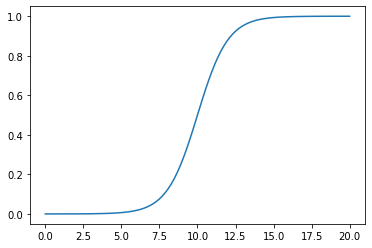

In [15]:
#make a figure of sigmoid with example maturity equation
def sigmoid(a):
    return(1/(1+np.exp(-1*(a-10))))
a = np.linspace(0,20,100)
plt.plot(a, sigmoid(a))

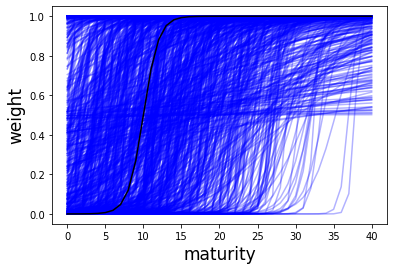

In [18]:
# try to visualise maturity slopes with prior a50 and S values
nsamp = 1000
a50 = np.random.normal(10, 10, nsamp)
S = np.random.exponential(1, nsamp)

ages = mdata.Age.unique()

#plot all possible ogives
[plt.plot(ages, 1/(1+np.exp(-S*(ages-a50))), c='blue', alpha=0.3) for a50,S in zip(a50, S)]
plt.xlabel('age', fontsize=10)
plt.ylabel('maturity', fontsize=10);

# a real ogive to see
plt.plot(ages, sigmoid(ages), c='black')

# Make it look nice
plt.xlabel('maturity', fontsize=17)
plt.ylabel('weight', fontsize=17);

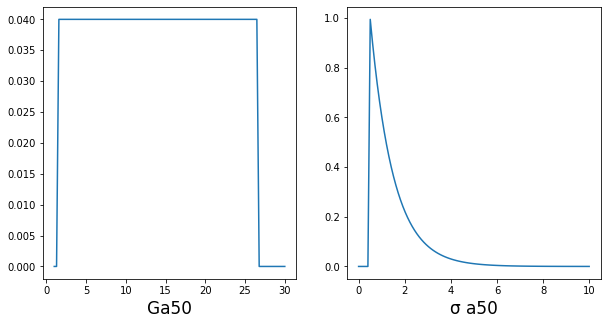

In [19]:
#visualise a50 priors here

# Setup multipanel figure
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,5))
ax_ = axes.flatten()

# Plot range of Ga50 prior
# create 100 values between 1 and 30
x = np.linspace(1, 30, 100) 
ax_[0].plot(x, sp.stats.uniform.pdf(x, 1.5, 25))
# specify labels for chart 1
ax_[0].set_xlabel('Ga50', fontsize=17)

# Plot range of sigma prior
#create 100 values between -10 and 60
x = np.linspace(0, 10, 100)
#what is the likelihood of each potential sigma value given your uniform prior where the mean=0 and std dev=50
ax_[1].plot(x, sp.stats.expon.pdf(x, 0.5))
ax_[1].set_xlabel('σ a50', fontsize=17);

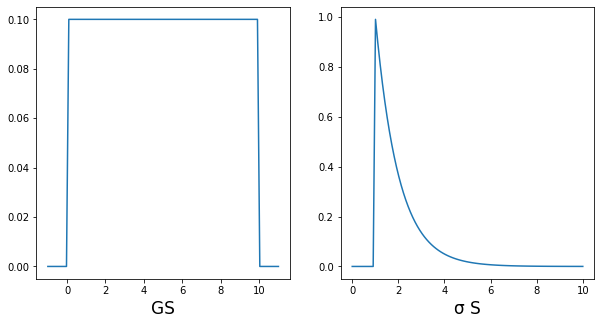

In [20]:
#visualise S priors here

# Setup multipanel figure
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,5))
ax_ = axes.flatten()

# Plot range of GS prior
x = np.linspace(-1, 11, 100) #make the x axis
ax_[0].plot(x, sp.stats.uniform.pdf(x, 0.01, 10))
# specify labels for chart 1
ax_[0].set_xlabel('GS', fontsize=17)

# Plot range of sigma prior
#create 100 values between -10 and 60
x = np.linspace(0, 10, 100)
#what is the likelihood of each potential sigma value given your uniform prior where the mean=0 and std dev=50
ax_[1].plot(x, sp.stats.expon.pdf(x, 1))
ax_[1].set_xlabel('σ S', fontsize=17);

### Model Specification

In [18]:
# random effects model (Aaron model)
with pm.Model() as mat1:
    
    # Hierarchical a50
    Ga50 = pm.Uniform('Ga50', 1.5, 25) #mean a50 has uniform distribution from 1.5 to 25
    a50_sigma = pm.Exponential('a50_sigma', 0.5) #std dev of a50 is exponential distribution with lambda of 0.5
    a50 = pm.Normal('a50x', Ga50, a50_sigma, shape=nstocks) #likelihood of a50 values given distributions of Ga50 and sigma_a50 (I think... what is shape for?)
    # set up priors for slope values between a50 and covariates
    # first argument is just a name not an actual dataset - doesn't need to match name of data array
    β1 = pm.Normal('Lmax', 0, 3) 
   # β2 = pm.Normal('Linf', 0, 3) # don't use Linf bc same thing as Lmax, also effect too similar to K
    β3 = pm.Normal('Depth', 0, 3)
    β4 = pm.Normal('K', 0, 3)
   # β5 = pm.Normal ('Habitat', 0, 3) # How to set this up for a categorical variable?
    β6 = pm.Normal('Interbirth_interval', 0, 3)
    β7 = pm.Normal('Amax', 0, 3)
    β8 = pm.Normal('Litter', 0, 3)
    β9 = pm.Normal('Offspring_size', 0, 3)
    β10 = pm.Normal('Trophic', 0, 3)
  #  β11 = pm.Normal('Lmat', 0, 3)  # Don't use Lmat because same thing as a50
    
    # Hierarchical S
    # S is the curve parameter determining steepness/shape of maturity curve
    # GS is mean of distribution describing what S is
    # S_sigma is standard dev of distribution around GS
    GS = pm.Uniform('GS', 0.01, 10) # Uniform distribution of possible S values from 0.01 to 10
    S_sigma = pm.Exponential('S_sigma', 1) #Exponential distribution of possible sigma values with lambda of 1
    S = pm.Normal('Sx', GS, S_sigma, shape=nstocks) 
    
    # priors for covariates of S
    B1 = pm.Normal('Lmax-S', 0, 3)
    B3 = pm.Normal('Depth-S', 0, 3)
    B4 = pm.Normal('K-S', 0, 3)
   # β5 = pm.Normal ('Habitat', 0, 3) # How to set this up for a categorical variable?
    B6 = pm.Normal('Interbirth_interval-S', 0, 3)
    B7 = pm.Normal('Amax-S', 0, 3)
    B8 = pm.Normal('Litter-S', 0, 3)
    B9 = pm.Normal('Offspring_size-S', 0, 3)
    B10 = pm.Normal('Trophic-S', 0, 3)
    # no lmat because treating S and a50 as if they behave separately
    
    
    # a50 model
    # put all parameters that influence a50 here (all the β params from above)
    mu_a50 = pm.Deterministic("mu_a50", a50 + β1*LMAX + β3*DEP + β4*K + β6*INTR + β7*AMAX + β8*LITT + β9*OFFSZ + β10*TROPH)
    #mu_a50 = pm.Deterministic("mu_a50", a50 + β1*LMAX) #try running model with 1 covariate to test for overfitting
 
    # Growth (S) model
    mu_S = pm.Deterministic("mu_S", S + B1*LMAX + B3*DEP + B4*K + B6*INTR + B7*AMAX + B8*LITT + B9*OFFSZ + B10*TROPH)
    
    # Growth model
    mu = 1/(1+tt.exp(-mu_S[Is]*(AGE-mu_a50[Is])))
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-mu_a50[Is])))
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-a50[Is])))

    # tt=under the hood modelling stuff - tensor flow package. makes exp work
    # Is is index values of stock codes

    # Likelihood
    S2 = pm.Uniform('S2', 0.0, 0.1) #variance for likelihood equation
    Yi = pm.Normal('Yi', mu, S2, observed=MAT)
    

In [19]:
# Sampling
# go back to 5000 for final run
with mat1:
    trace1 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S2, Trophic-S, Offspring_size-S, Litter-S, Amax-S, Interbirth_interval-S, K-S, Depth-S, Lmax-S, Sx, S_sigma, GS, Trophic, Offspring_size, Litter, Amax, Interbirth_interval, K, Depth, Lmax, a50x, a50_sigma, Ga50]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 39781 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [21]:
for RV in mat1.basic_RVs:
    print(RV.name, RV.logp(mat1.test_point))

Ga50_interval__ -1.3862943611198906
a50_sigma_log__ -1.0596601002984287
a50x -28.64817430640816
Lmax -2.0175508218727827
Depth -2.0175508218727827
K -2.0175508218727827
Interbirth_interval -2.0175508218727827
Amax -2.0175508218727827
Litter -2.0175508218727827
Offspring_size -2.0175508218727827
Trophic -2.0175508218727827
GS_interval__ -1.3862943611198906
S_sigma_log__ -1.0596601002984287
Sx -12.705789153529404
Lmax-S -2.0175508218727827
Depth-S -2.0175508218727827
K-S -2.0175508218727827
Interbirth_interval-S -2.0175508218727827
Amax-S -2.0175508218727827
Litter-S -2.0175508218727827
Offspring_size-S -2.0175508218727827
Trophic-S -2.0175508218727827
S2_interval__ -1.3862943611198904
Yi -28670.6496425569


C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\arviz\plots\traceplot.py:195: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (25), generating only 20 plots
  UserWarning,


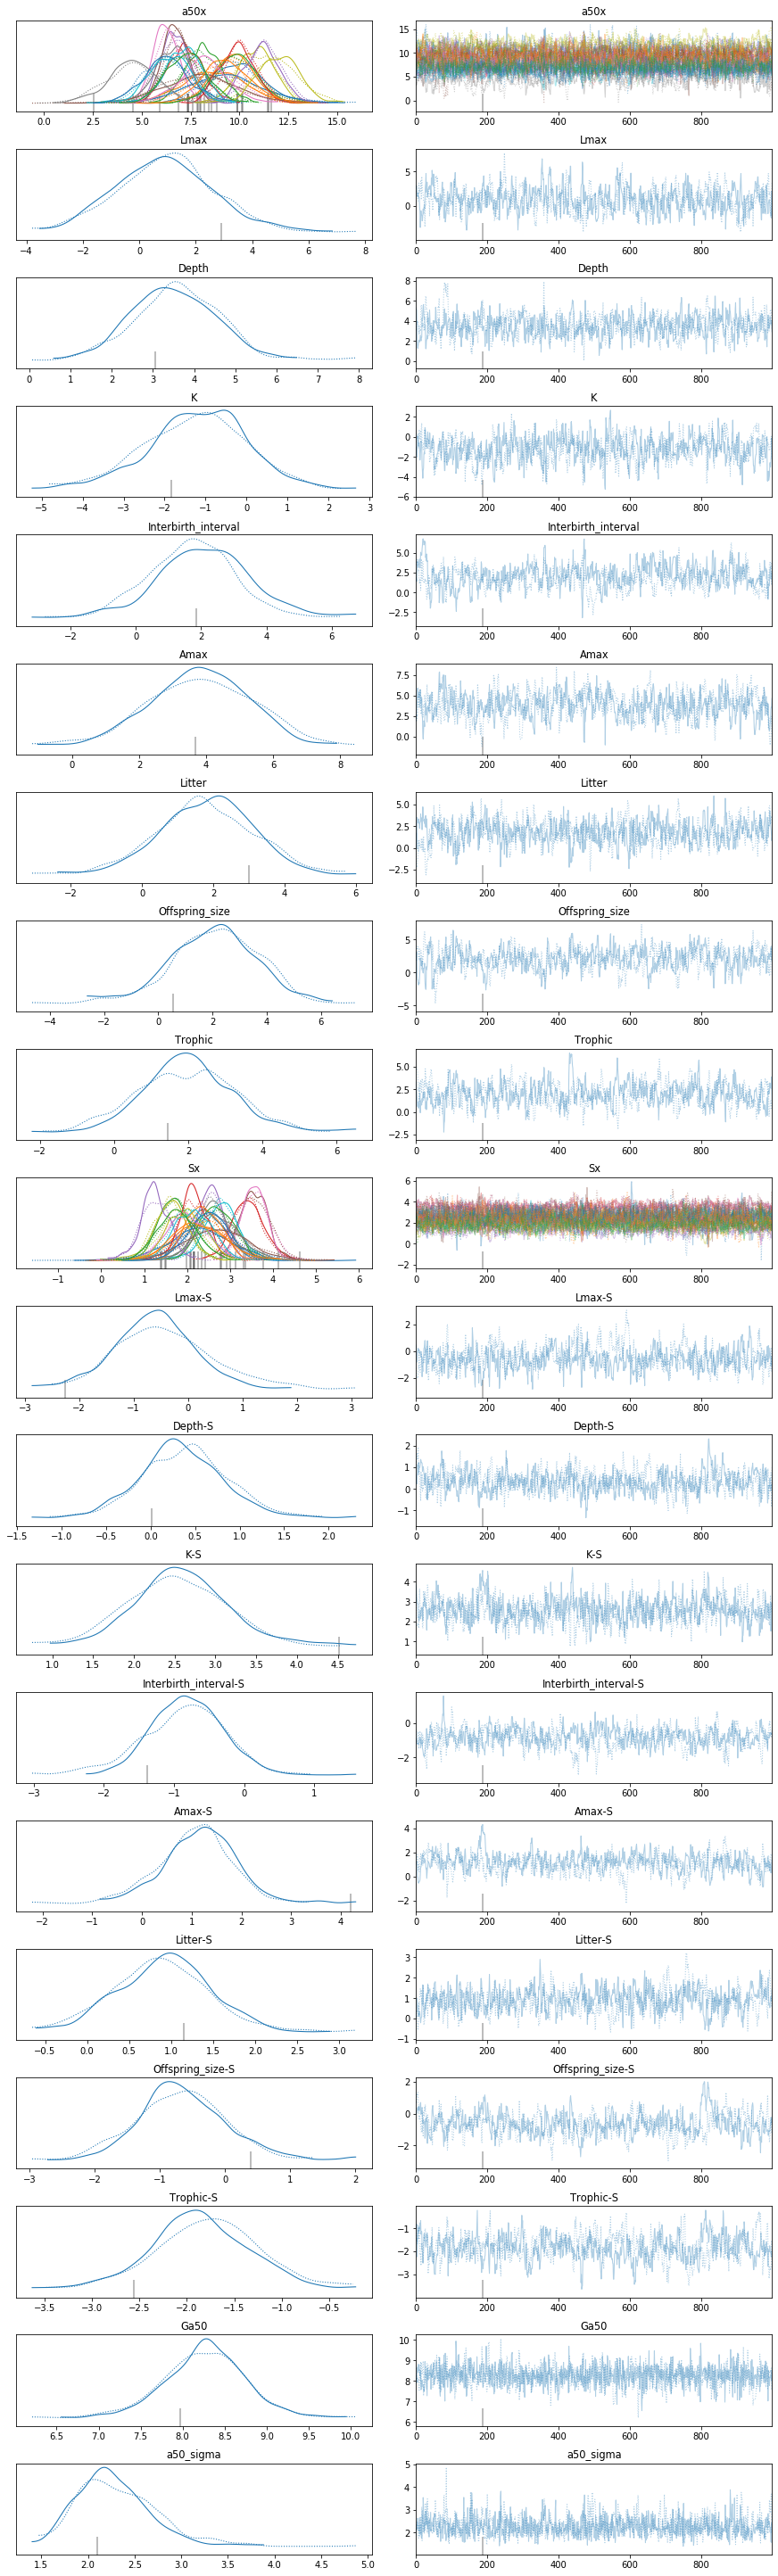

In [22]:
#check model performance
#warnings.filterwarnings("Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used", 'once')
pm.traceplot(trace1);

In [24]:
pm.summary(trace1)
# looking for r-hat valeus of 1 - shows that model is converging

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a50x[0]   9.775  1.343   7.159   12.310      0.116    0.083     135.0   132.0   
a50x[1]   8.755  1.649   5.590   11.758      0.082    0.059     400.0   393.0   
a50x[2]   8.078  0.985   6.234    9.815      0.075    0.053     173.0   173.0   
a50x[3]   7.131  0.986   5.280    8.869      0.075    0.053     173.0   173.0   
a50x[4]   6.807  0.765   5.443    8.261      0.052    0.037     215.0   214.0   
...         ...    ...     ...      ...        ...      ...       ...     ...   
mu_S[19]  0.657  0.010   0.639    0.675      0.000    0.000    1950.0  1948.0   
mu_S[20]  2.633  0.074   2.493    2.772      0.002    0.001    2016.0  2016.0   
mu_S[21]  5.215  0.559   4.330    6.246      0.028    0.021     395.0   343.0   
mu_S[22]  1.197  0.024   1.157    1.245      0.001    0.000    1774.0  1773.0   
S2        0.008  0.000   0.008    0.009      0.000    0.000    1129.0  1129.0   

          ess_bulk  ess_tail  r_hat  
a50x[0]      136.0     264.0   1.02  
a50x[1]      405.0     508.0   1.00  
a50x[2]      174.0     517.0   1.01  
a50x[3]      174.0     509.0   1.01  
a50x[4]      216.0     382.0   1.01  
...            ...       ...    ...  
mu_S[19]    1944.0    1533.0   1.00  
mu_S[20]    2013.0    1184.0   1.00  
mu_S[21]     706.0     340.0   1.00  
mu_S[22]    1772.0    1422.0   1.00  
S2          1119.0     959.0   1.00  

[113 rows x 11 columns]

In [38]:
# fixed effect model (Seb model)
with pm.Model() as mat2:
    
    # Hierarchical a50
    Ga50 = pm.Uniform('Ga50', 1.5, 25) #mean a50 has uniform distribution from 1.5 to 25
    #a50_sigma = pm.Exponential('a50_sigma', 0.5) #std dev of a50 is exponential distribution with lambda of 0.5
    #a50 = pm.Normal('a50x', Ga50, a50_sigma) #likelihood of a50 values given distributions of Ga50 and sigma_a50 (I think... what is shape for?)
    # set up priors for slope values between a50 and covariates
    # first argument is just a name not an actual dataset - doesn't need to match name of data array
    β1 = pm.Normal('Lmax', 0, 3) 
   # β2 = pm.Normal('Linf', 0, 3)
    β3 = pm.Normal('Depth', 0, 3)
    β4 = pm.Normal('K', 0, 3)
   # β5 = pm.Normal ('Habitat', 0, 3) # How to set this up for a categorical variable?
    β6 = pm.Normal('Interbirth_interval', 0, 3)
    β7 = pm.Normal('Amax', 0, 3)
    β8 = pm.Normal('Litter', 0, 3)
    β9 = pm.Normal('Offspring_size', 0, 3)
    β10 = pm.Normal('Trophic', 0, 3)
 #   β11 = pm.Normal('Lmat', 0, 3)
    
    # Hierarchical S
    # S is the curve parameter determining steepness/shape of maturity curve
    # GS is mean of distribution describing what S is
    # S_sigma is standard dev of distribution around GS
     
    GS = pm.Uniform('GS', 0.01, 10) # Uniform distribution of possible S values from 0.01 to 10
    #S_sigma = pm.Exponential('S_sigma', 1) #Exponential distribution of possible sigma values with lambda of 1
    #S = pm.Normal('Sx', GS, S_sigma, shape=nstocks) 
    
    # now put all the priors for covariates of S
    B1 = pm.Normal('Lmax-S', 0, 3)
    B3 = pm.Normal('Depth-S', 0, 3)
    B4 = pm.Normal('K-S', 0, 3)
   # β5 = pm.Normal ('Habitat', 0, 3) # How to set this up for a categorical variable?
    B6 = pm.Normal('Interbirth_interval-S', 0, 3)
    B7 = pm.Normal('Amax-S', 0, 3)
    B8 = pm.Normal('Litter-S', 0, 3)
    B9 = pm.Normal('Offspring_size-S', 0, 3)
    B10 = pm.Normal('Trophic-S', 0, 3)
 #   B11 = pm.Normal('Lmat-S', 0, 3)
    
    # a50 model
    # put all parameters that influence a50 here (all the β params from above)
    mu_a50 = pm.Deterministic("mu_a50", Ga50 + β1*LMAX + β3*DEP + β4*K + β6*INTR + β7*AMAX + β8*LITT + β9*OFFSZ + β10*TROPH)
 
    # Growth (S) model
    #put all parameters that influence S here 
    mu_S = pm.Deterministic("mu_S", GS + B1*LMAX + B3*DEP + B4*K + B6*INTR + B7*AMAX + B8*LITT + B9*OFFSZ + B10*TROPH)
    
    # Growth model
    # should there be an index for mu_S here? shouldn't there be just one s value?
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-a50[Is])))
    mu = 1/(1+tt.exp(-mu_S[Is]*(AGE-mu_a50[Is])))

    # tt=under the hood modelling stuff - tensor flow package. makes exp work
    # Is is index values of stock codes

    # Likelihood
    S2 = pm.Uniform('S2', 0.0, 0.1) 
    Yi = pm.Normal('Yi', mu, S2, observed=MAT)
    

In [39]:
# Sampling
# go back to 5000 for final run
with mat2:
    trace2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S2, Trophic-S, Offspring_size-S, Litter-S, Amax-S, Interbirth_interval-S, K-S, Depth-S, Lmax-S, GS, Trophic, Offspring_size, Litter, Amax, Interbirth_interval, K, Depth, Lmax, Ga50]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10543 seconds.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8811805027617768, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [42]:
import warnings
warnings.filterwarnings("ignore")
# warnings.filterwarnings("ignore", category=UserWarning)

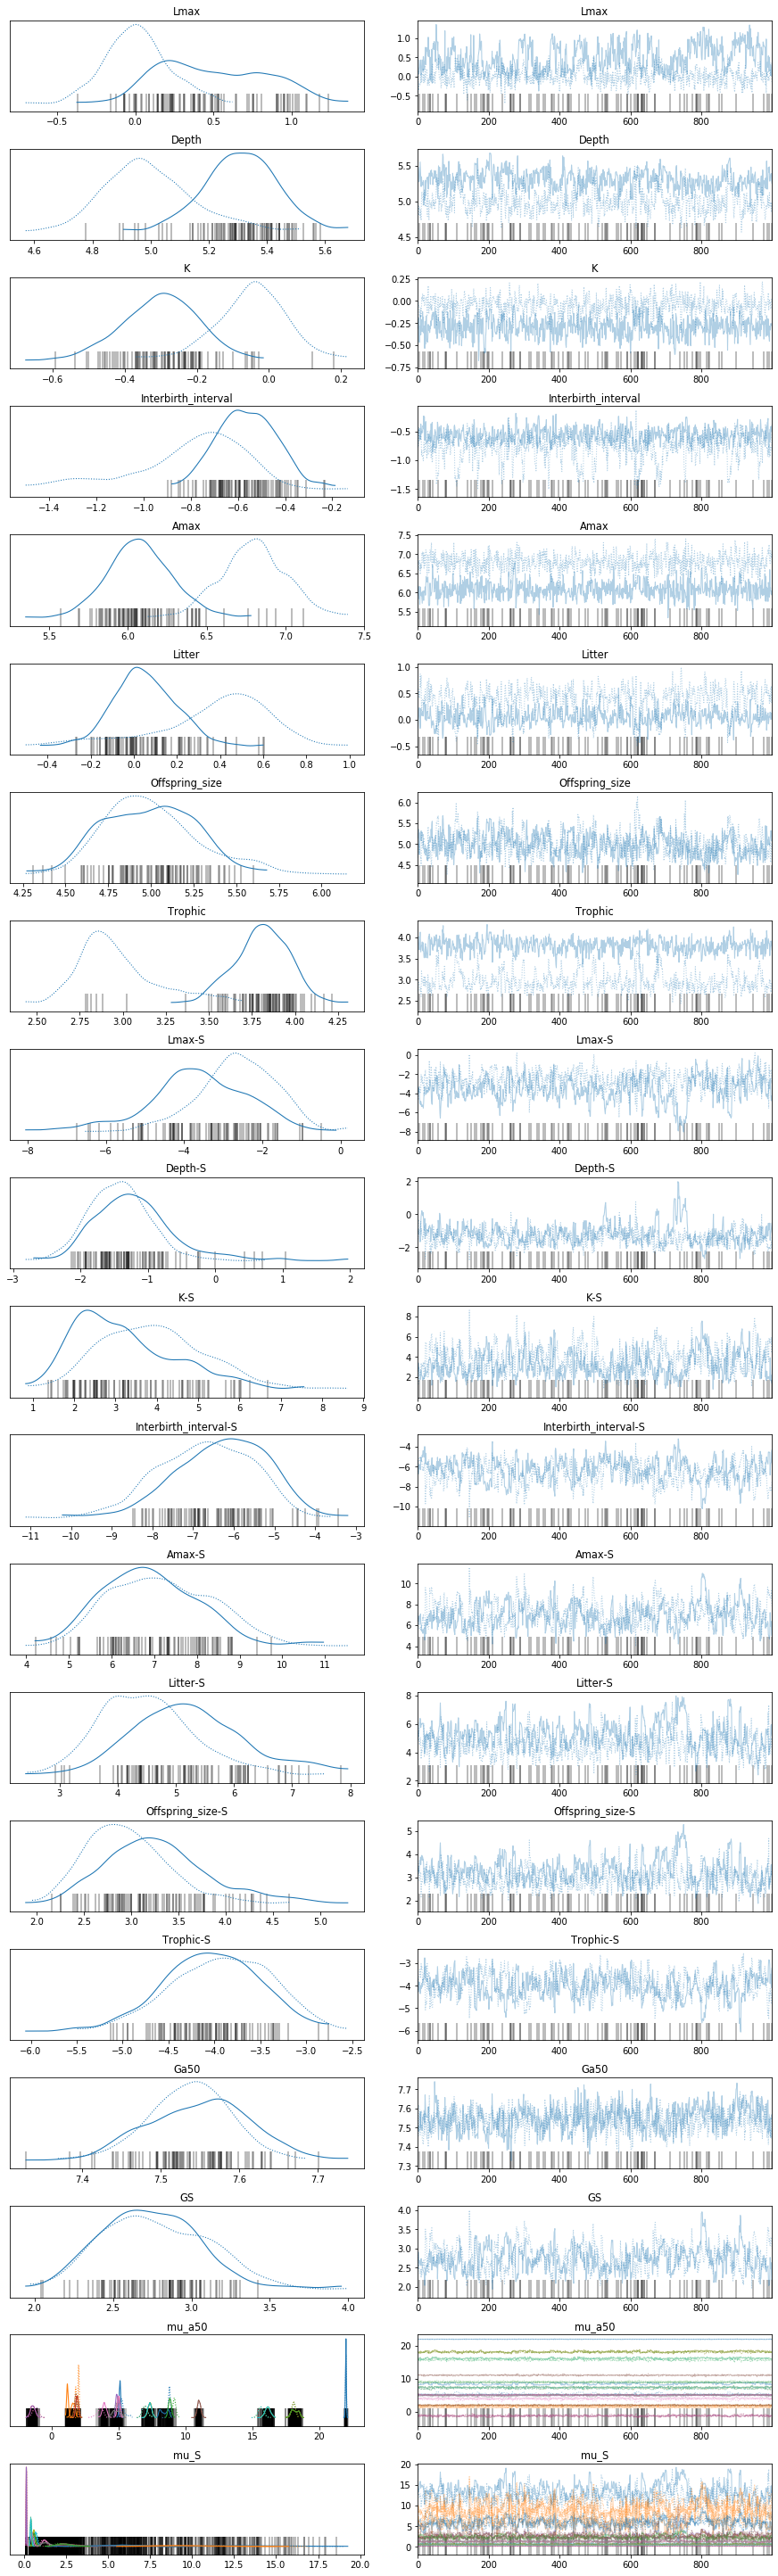

In [43]:
#check model performance
pm.traceplot(trace2);

In [39]:
pm.summary(trace2)
# looking for r-hat valeus of 1 - shows that model is converging

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  \
Lmax                  0.486  0.197   0.132    0.833      0.008    0.006   
Depth                 6.771  0.110   6.563    6.960      0.003    0.002   
K                     0.175  0.066   0.056    0.298      0.002    0.001   
Interbirth_interval  -1.441  0.125  -1.684   -1.206      0.004    0.003   
Amax                  7.035  0.188   6.663    7.369      0.005    0.004   
...                     ...    ...     ...      ...        ...      ...   
mu_S[20]              0.415  0.042   0.343    0.495      0.001    0.001   
mu_S[21]              6.553  1.042   4.618    8.511      0.047    0.034   
mu_S[22]             10.579  1.579   7.562   13.432      0.071    0.051   
mu_S[23]              1.808  0.270   1.315    2.315      0.009    0.007   
S2                    0.100  0.000   0.100    0.100      0.000    0.000   

                     ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
Lmax                    608.0   608.0     767.0     593.0    1.0  
Depth                  1177.0  1177.0    1195.0     955.0    1.0  
K                      1436.0  1436.0    1468.0    1146.0    1.0  
Interbirth_interval    1069.0  1069.0    1078.0    1031.0    1.0  
Amax                   1235.0  1234.0    1222.0    1289.0    1.0  
...                       ...     ...       ...       ...    ...  
mu_S[20]               1869.0  1836.0    1898.0    1438.0    1.0  
mu_S[21]                483.0   473.0     487.0     702.0    1.0  
mu_S[22]                489.0   481.0     494.0     759.0    1.0  
mu_S[23]                812.0   812.0     804.0    1225.0    1.0  
S2                     2461.0  2461.0    1644.0     874.0    1.0  

[67 rows x 11 columns]

### Model Results

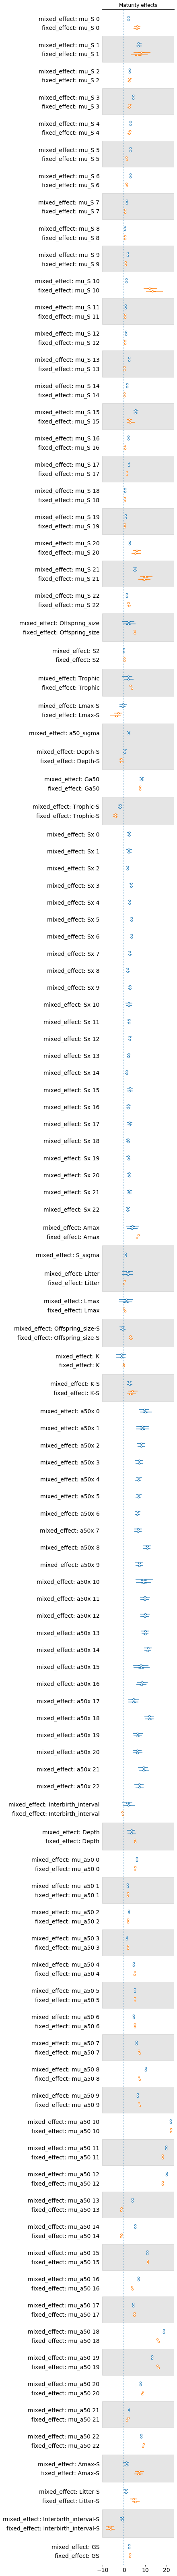

<Figure size 432x288 with 0 Axes>

In [126]:
# Forest plot to see size and direction of cov effects
# Compare mat1 and mat2 (mixed effect vs fixed effect)
# az.style.use("arviz-darkgrid")
axes = az.plot_forest(
    [trace1, trace2], model_names=["mixed_effect", "fixed_effect"])
axes[0].set_title("Maturity effects")
plt.axvline(0, linestyle=':')
plt.show()

#save figure
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Data\\for model\\out')
plt.savefig('mat1&2_forest.jpg');

### Model Comparison

In [25]:
#WAIC for model 1
pm.waic(trace1, scale='deviance')

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:1427: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 2000 by 505 log-likelihood matrix

              Estimate       SE
deviance_waic -3286.24   127.33
p_waic           91.55        -

There has been a warning during the calculation. Please check the results.

In [46]:
#WAIC for model 2
pm.waic(trace2, scale='deviance')

Computed from 2000 by 505 log-likelihood matrix

              Estimate       SE
deviance_waic   181.36   378.46
p_waic          330.40        -

There has been a warning during the calculation. Please check the results.

Model 1 WAIC = -3286  
Model 2 WAIC = 181  

Model 1 vastly preferred over model 2 as lower WAIC better than higher

#### Look for 'bad' datapoints

In [26]:
loo1 = pm.loo(trace1, mat1)
loo1

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:684: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 2000 by 505 log-likelihood matrix

         Estimate       SE
elpd_loo  1633.63    63.76
p_loo      101.04        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      460   91.1%
 (0.5, 0.7]   (ok)         19    3.8%
   (0.7, 1]   (bad)        17    3.4%
   (1, Inf)   (very bad)    9    1.8%

In [104]:
# show bad datapoints
mdata.iloc[loo1.pareto_k.values > 0.7]

Species     Stock   Stock_Year  Age  maturity  \
6         Carcharhinus tilstoni  ABTP-SWP  ABTP-SWP-13    6  0.487169   
18   Rhizoprionodon terraenovae  ATSH-GOM  ATSH-GOM-03    2  0.935078   
29   Rhizoprionodon terraenovae  ATSH-NWA  ATSH-NWA-07    2  0.320000   
30   Rhizoprionodon terraenovae  ATSH-NWA  ATSH-NWA-07    3  0.870000   
63       Carcharhinus acronotus  BNOS-GOM  BNOS-GOM-11    4  0.175100   
64       Carcharhinus acronotus  BNOS-GOM  BNOS-GOM-11    5  0.819100   
79       Carcharhinus acronotus  BNOS-NWA  BNOS-NWA-07    5  0.500000   
92       Carcharhinus acronotus  BNOS-NWA  BNOS-NWA-11    4  0.175100   
93       Carcharhinus acronotus  BNOS-NWA  BNOS-NWA-11    5  0.819100   
248     Carcharhinus brachyurus   COP-SWA   COP-SWA-03   21  0.236438   
249     Carcharhinus brachyurus   COP-SWA   COP-SWA-03   22  0.570582   
251     Carcharhinus brachyurus   COP-SWA   COP-SWA-03   24  0.881287   
389  Carcharhinus amblyrhynchos   GRE-SWP   GRE-SWP-06   11  0.502273   
417         Carcharhinus cautus     NER-I     NER-I-02    6  0.176052   
418         Carcharhinus cautus     NER-I     NER-I-02    7  0.611175   
434     Carcharhinus longimanus   OCW-WCP   OCW-WCP-12    4  0.341000   
435     Carcharhinus longimanus   OCW-WCP   OCW-WCP-12    5  0.822000   
511       Carcharhinus plumbeus   SAN-NWA   SAN-NWA-06   13  0.010000   
512       Carcharhinus plumbeus   SAN-NWA   SAN-NWA-06   14  0.050000   
515       Carcharhinus plumbeus   SAN-NWA   SAN-NWA-06   17  0.350000   
517       Carcharhinus plumbeus   SAN-NWA   SAN-NWA-06   19  0.600000   
519       Carcharhinus plumbeus   SAN-NWA   SAN-NWA-06   21  0.700000   
630     Carcharhinus brevipinna   SPIN-WP   SPIN-WP-05    7  0.142857   
631     Carcharhinus brevipinna   SPIN-WP   SPIN-WP-05    8  0.666667   
632     Carcharhinus brevipinna   SPIN-WP   SPIN-WP-05    9  1.000000   
647         Carcharhinus sorrah   SPT-SWP   SPT-SWP-13    2  0.252713   

    survivorship  fecundity (num female pups per year)  \
6            NaN                                   NaN   
18           NaN                                   NaN   
29           NaN                                 1.312   
30           NaN                                 3.567   
63        0.7799                                 2.500   
64        0.7888                                 2.500   
79           NaN                                 1.665   
92        0.7911                                 2.500   
93        0.7911                                 2.500   
248          NaN                                   NaN   
249          NaN                                   NaN   
251          NaN                                   NaN   
389          NaN                                 0.000   
417          NaN                                   NaN   
418          NaN                                   NaN   
434         0.82                                   NaN   
435         0.82                                   NaN   
511          NaN                                 0.042   
512          NaN                                 0.210   
515          NaN                                 1.470   
517          NaN                                 2.520   
519          NaN                                 2.940   
630          NaN                                   NaN   
631          NaN                                   NaN   
632          NaN                                   NaN   
647          NaN                                   NaN   

                                                 notes  \
6                                                  NaN   
18                                                 NaN   
29                                                 NaN   
30                                                 NaN   
63   survivorship= 1-M; fecundity = mat*average of ...   
64   survivorship= 1-M; fecundity = mat*average of ...   
79                                                 NaN   
92                   

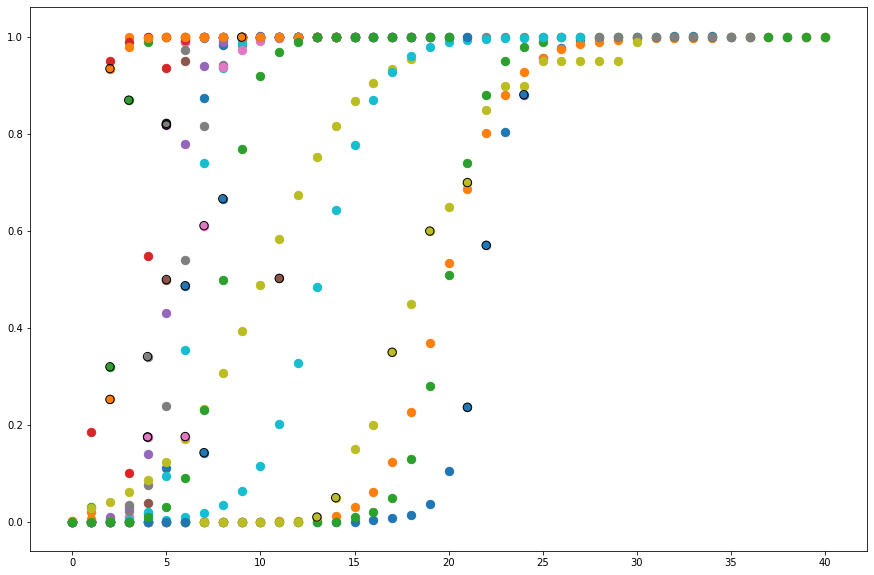

In [120]:
# Plot points with bad pareto k scores

badpoints1 = mdata.iloc[loo1.pareto_k.values > 0.7]

plt.figure(figsize=(15,10))
[plt.scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s], s=70) for s in StockYr]
plt.scatter(badpoints1.Age, badpoints1.maturity, facecolors='none', edgecolors='k', s=70)


In [47]:
loo2 = pm.loo(trace2, mat2)
loo2

Computed from 2000 by 505 log-likelihood matrix

         Estimate       SE
elpd_loo    72.82    76.99
p_loo      166.90        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      469   92.9%
 (0.5, 0.7]   (ok)         10    2.0%
   (0.7, 1]   (bad)        14    2.8%
   (1, Inf)   (very bad)   12    2.4%

In [117]:
badpoints2 = mdata.iloc[loo2.pareto_k.values > 0.7]
mdata.iloc[loo2.pareto_k.values > 0.7]

Species     Stock   Stock_Year  Age  maturity  \
5         Carcharhinus tilstoni  ABTP-SWP  ABTP-SWP-13    5  0.112019   
17   Rhizoprionodon terraenovae  ATSH-GOM  ATSH-GOM-03    1  0.021383   
18   Rhizoprionodon terraenovae  ATSH-GOM  ATSH-GOM-03    2  0.935078   
19   Rhizoprionodon terraenovae  ATSH-GOM  ATSH-GOM-03    3  1.000000   
29   Rhizoprionodon terraenovae  ATSH-NWA  ATSH-NWA-07    2  0.320000   
42   Rhizoprionodon terraenovae  ATSH-NWA  ATSH-NWA-13    2  0.950000   
62       Carcharhinus acronotus  BNOS-GOM  BNOS-GOM-11    3  0.009900   
64       Carcharhinus acronotus  BNOS-GOM  BNOS-GOM-11    5  0.819100   
249     Carcharhinus brachyurus   COP-SWA   COP-SWA-03   22  0.570582   
386  Carcharhinus amblyrhynchos   GRE-SWP   GRE-SWP-06    8  0.000000   
389  Carcharhinus amblyrhynchos   GRE-SWP   GRE-SWP-06   11  0.502273   
390  Carcharhinus amblyrhynchos   GRE-SWP   GRE-SWP-06   12  1.000000   
392  Carcharhinus amblyrhynchos   GRE-SWP   GRE-SWP-06   14  1.000000   
411         Carcharhinus cautus     NER-I     NER-I-02    0  0.000000   
412         Carcharhinus cautus     NER-I     NER-I-02    1  0.000000   
413         Carcharhinus cautus     NER-I     NER-I-02    2  0.000000   
414         Carcharhinus cautus     NER-I     NER-I-02    3  0.000000   
416         Carcharhinus cautus     NER-I     NER-I-02    5  0.001134   
417         Carcharhinus cautus     NER-I     NER-I-02    6  0.176052   
429         Carcharhinus cautus     NER-I     NER-I-02   18  1.000000   
435     Carcharhinus longimanus   OCW-WCP   OCW-WCP-12    5  0.822000   
440     Carcharhinus longimanus   OCW-WCP   OCW-WCP-12   10  1.000000   
632     Carcharhinus brevipinna   SPIN-WP   SPIN-WP-05    9  1.000000   
633     Carcharhinus brevipinna   SPIN-WP   SPIN-WP-05   10  1.000000   
646         Carcharhinus sorrah   SPT-SWP   SPT-SWP-13    1  0.006895   
669           Triaenodon obesus  WTIP-SWP  WTIP-SWP-06    9  0.770000   

    survivorship  fecundity (num female pups per year)  \
5            NaN                                   NaN   
17           NaN                                   NaN   
18           NaN                                   NaN   
19           NaN                                   NaN   
29           NaN                              1.312000   
42         0.768                              0.978000   
62        0.7663                              2.500000   
64        0.7888                              2.500000   
249          NaN                                   NaN   
386          NaN                              0.000000   
389          NaN                              0.000000   
390          NaN                              0.536300   
392          NaN                              1.533958   
411          NaN                                   NaN   
412          NaN                                   NaN   
413          NaN                                   NaN   
414          NaN                                   NaN   
416          NaN                                   NaN   
417          NaN                                   NaN   
429          NaN                                   NaN   
435         0.82                                   NaN   
440         0.82                                   NaN   
632          NaN                                   NaN   
633          NaN                                   NaN   
646          NaN                                   NaN   
669          NaN                              1.035000   

                                                 notes  \
5                                                  NaN   
17                                                 NaN   
18                                                 NaN   
19                                                 NaN   
29                                                 NaN   
42   age 0 survivorship from section 3.2.6, alpha h...   
62   survivorship= 1-M; fecundity = mat*average of ...   
64   survivorship= 1-

### Plot model fits

In [57]:
# Save results to external file - mat1
result1 = pm.backends.tracetab.trace_to_dataframe(trace1)

# Edit column names
colnames = np.array(list(result1.columns), dtype=object)

colnames[np.array([list(colnames).index(x) for x in grep('a50x',colnames)])] = np.array(['a50_'+str(s) for s in StockYr])
colnames[np.array([list(colnames).index(x) for x in grep('Sx',colnames)])] = np.array(['S_'+str(s) for s in StockYr])

result1.columns = list(colnames)

# each model run produces an a50 and S value for each stock-year
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Data\\for model\\out')
result1.to_csv('mat1_model_results.csv')
result1.head()

a50_ABTP-SWP-13  a50_ATSH-GOM-03  a50_ATSH-NWA-07  a50_ATSH-NWA-13  \
0        10.118642         8.982885         8.386427         7.444969   
1         9.894401         9.386842         8.255870         7.302033   
2         9.036459         9.001660         8.769679         7.839815   
3        11.681592        10.453030         8.994270         8.036227   
4        12.693521         7.826114         9.141234         8.172397   

   a50_BNOS-GOM-11  a50_BNOS-NWA-07  a50_BNOS-NWA-11  a50_BTIP-GOM-05  \
0         8.078523         8.051465         7.537102         5.969402   
1         8.246015         8.058252         7.543204         6.636303   
2         7.921626         8.001858         7.512591         6.227230   
3         6.403004         6.109549         5.628533         7.601891   
4         5.289093         5.795271         5.315926         8.120888   

   a50_BTIP-GOM-12  a50_BTIP-NWA-06  ...  mu_S__14  mu_S__15  mu_S__16  \
0        10.191365         6.464884  ...  1.608538  5.784877  2.080677   
1        10.907506         7.201932  ...  1.575304  4.943716  2.037210   
2        10.468312         6.750229  ...  1.575033  5.256000  2.150876   
3        11.847838         8.160794  ...  1.569786  5.086429  2.112018   
4        12.346584         8.605016  ...  1.580000  6.446762  2.113597   

   mu_S__17  mu_S__18  mu_S__19  mu_S__20  mu_S__21  mu_S__22        S2  
0  2.172513  0.476435  0.671794  2.738110  4.821683  1.210609  0.008891  
1  2.196505  0.466504  0.654816  2.794082  4.669567  1.183772  0.008425  
2  2.248438  0.480953  0.662061  2.673753  4.967803  1.227117  0.008717  
3  2.309937  0.492279  0.648417  2.541569  5.732529  1.161933  0.008157  
4  2.279909  0.480986  0.665019  2.530342  5.054527  1.187919  0.008355  

[5 rows x 113 columns]

In [125]:
# Save results to external file - mat2
result2 = pm.backends.tracetab.trace_to_dataframe(trace2)

# Edit column names
colnames = np.array(list(result2.columns), dtype=object)
colnames[np.array([list(colnames).index(x) for x in grep('mu_a50',colnames)])] = np.array(['a50_'+str(s) for s in StockYr])
colnames[np.array([list(colnames).index(x) for x in grep('mu_S',colnames)])] = np.array(['S_'+str(s) for s in StockYr])

#colnames[np.array([list(colnames).index(x) for x in grep('Sx',colnames)])] = np.array(['S_'+str(s) for s in StockYr])

# take new names from text replacement commands and inserts them into df column names
result2.columns = list(colnames)

os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Data\\for model\\out')
result2.to_csv('mat2_model_results.csv')
result2.head()

Lmax     Depth         K  Interbirth_interval      Amax    Litter  \
0  0.545120  5.488694 -0.290662            -0.767568  6.169914 -0.153681   
1  0.410120  5.483450 -0.310375            -0.771326  6.106650 -0.130348   
2  0.428641  5.478354 -0.293719            -0.640960  5.924926  0.000491   
3  0.074115  5.435592 -0.191289            -0.462923  6.068374  0.042133   
4  0.086395  5.275433 -0.356441            -0.515835  5.844751  0.171887   

   Offspring_size   Trophic    Lmax-S   Depth-S  ...  S_FTH-NWA-07  \
0        5.252050  3.982580 -3.989272 -1.139724  ...      0.152325   
1        5.253170  3.970493 -4.148487 -1.113925  ...      0.132502   
2        5.146614  4.021478 -3.356138 -0.906869  ...      0.151776   
3        5.353176  3.845360 -3.920481 -1.213880  ...      0.150100   
4        5.269632  3.762727 -3.627738 -1.090408  ...      0.135047   

   S_GRE-SWP-06  S_NER-I-02  S_OCW-WCP-12  S_SAN-NWA-06  S_SAN-NWA-11  \
0      2.500742    0.367233      0.969870      0.361776      0.361776   
1      2.529144    0.533062      0.885735      0.457072      0.457072   
2      3.973626    0.407289      1.833741      0.422740      0.422740   
3      2.744830    0.449316      1.111847      0.396526      0.396526   
4      3.152358    0.505301      1.589450      0.387852      0.387852   

   S_SPIN-WP-05  S_SPT-SWP-13  S_WTIP-SWP-06        S2  
0      4.696856      8.382128       2.529544  0.099695  
1      4.559602      8.275742       2.512923  0.099683  
2      5.796184     10.047727       2.416308  0.099806  
3      5.199365      9.188092       2.534097  0.099573  
4      5.280133      9.045251       2.345588  0.099830  

[5 rows x 65 columns]

In [85]:
# Grab data from mat1 results
# Grab a50's
# take median mu_a50 value for each stock-year to visualise effect of covs on a50
μa50s = np.array([np.median(result1[x]) for x in np.array(['mu_a50__'+str(s) for s in list(range(len(StockYr)))])]).T

# can also just look at a50s
a50s = np.array([np.median(result1[x]) for x in np.array(['a50_'+str(s) for s in StockYr])]).T

# Grab S's
μSs = np.array([np.median(result1[x]) for x in np.array(['mu_S__'+str(s) for s in list(range(len(StockYr)))])]).T
Ss = np.array([np.median(result1[x]) for x in np.array(['S_'+str(s) for s in StockYr])]).T

# xrange
xr = np.linspace(0,max(AGE),max(AGE).astype(int)+1)

In [79]:
# Grab data from mat2 results
# Grab a50's
# take median mu_a50 value for each stock-year to visualise effect of covs on a50
#μa50s2 = np.array([np.median(result2[x]) for x in np.array(['a50_'+str(s) for s in list(range(len(StockYr)))])]).T
a50s2 = np.array([np.median(result2[x]) for x in np.array(['a50_'+str(s) for s in StockYr])]).T

# Grab S's
Ss2 = np.array([np.median(result2[x]) for x in np.array(['S_'+str(s) for s in StockYr])]).T
# Ss2 = np.median(result2.GS)

# xrange
# Make a vector of ages from 0 to max age
xr = np.linspace(0,max(AGE),max(AGE).astype(int)+1)

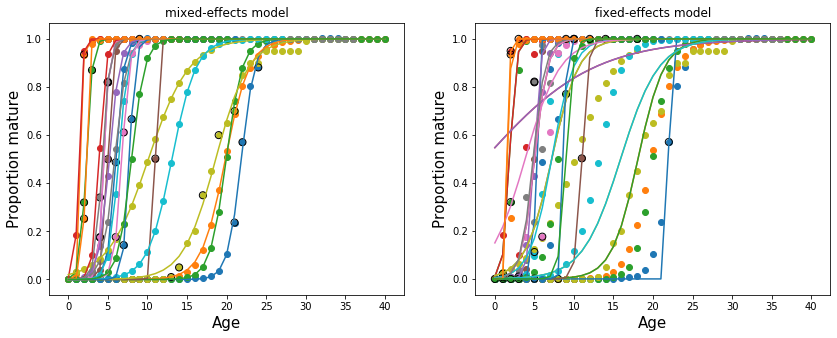

In [124]:
#set up figure
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14,5))
ax_ = axes.flatten()

#Plot mat1
#scatter plot of mat and age data
[ax_[0].scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
# add markers for points with bad pareto k scores
ax_[0].scatter(badpoints1.Age, badpoints1.maturity, facecolors='none', edgecolors='k', s=50)
#plot ogives with median S and mu_a50 values
[ax_[0].plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(μSs,μa50s)]
#make plot pretty
ax_[0].set_xlabel('Age',fontsize=15)
ax_[0].set_ylabel('Proportion mature',fontsize=15)
ax_[0].set_title('mixed-effects model')

#Plot mat2
#scatter plot of mat and age data
[ax_[1].scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
# add markers for poitns with high pareto k scores
ax_[1].scatter(badpoints2.Age, badpoints2.maturity, facecolors='none', edgecolors='k', s=50)
#plot ogives with median S and mu_a50 values
[ax_[1].plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(Ss2,a50s2)]
#make plot pretty
ax_[1].set_xlabel('Age',fontsize=15)
ax_[1].set_ylabel('Proportion mature',fontsize=15)
ax_[1].set_title('fixed-effects model')

#save results
plt.savefig('mat1_mat2_modelfit.jpg',dpi=300);

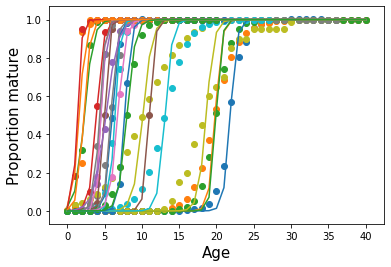

In [33]:
#plot model results against raw data - single plot model 1

#scatter plot of mat and age data
[plt.scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
#plot ogives with median S and mu_a50 values
[plt.plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(Ss,μa50s)]
#make plot pretty
plt.xlabel('Age',fontsize=15)
plt.ylabel('Proportion mature',fontsize=15)

#save results
plt.savefig('mat1_modelfit.jpg',dpi=300);

In [73]:
Ss2

array([2.41178274, 2.30866238, 1.67913289, 3.39928098, 2.57243714,
       3.56210777, 3.57935904, 2.55367245, 1.61390551, 2.78732866,
       2.30249855, 2.36003238, 2.686261  , 2.14951137, 1.2475989 ,
       2.72122127, 1.9756955 , 2.6882059 , 1.91768788, 2.08606105,
       2.51139257, 2.3440015 , 1.79499276])

In [74]:
a50s

array([ 9.76009365,  8.68625762,  8.06602776,  7.12369612,  6.77378649,
        6.79723211,  6.30789755,  6.64664705, 10.88479322,  7.17738067,
        9.23101444,  9.7489099 ,  9.86614281,  9.97706556, 11.24367088,
        7.90454959,  8.28547429,  4.50911785, 11.94163056,  6.40679289,
        6.24938464,  9.20694622,  7.21781041])

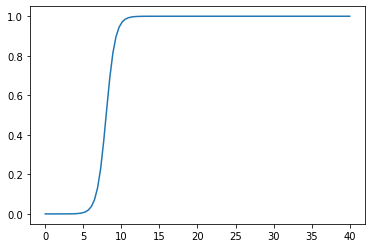

In [78]:
#double check model 1 fit
def sigmoid(a):
    return(1/(1+np.exp(-1.67*(a-8))))
a = np.linspace(0,40,100)
plt.plot(a, sigmoid(a))

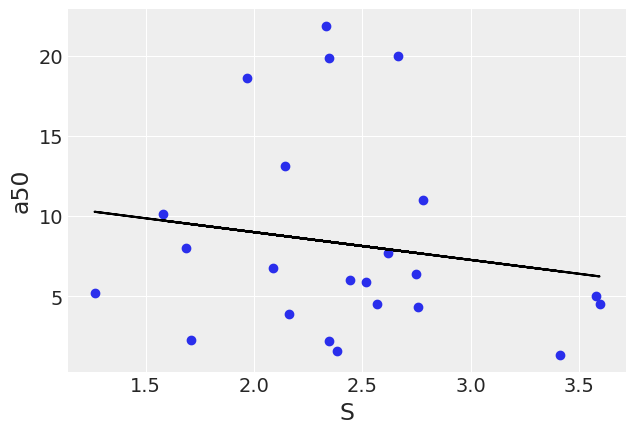

In [84]:
# Look at relationship betweeen a50 and s
plt.scatter(Ss, μa50s)

b1,b0 = np.polyfit(Ss,μa50s, 1)
plt.plot(Ss,b0+b1*Ss,c='black')


plt.xlabel('S', fontsize=17)
plt.ylabel('a50', fontsize=17);